# 消費者分群
## 使用 [電商零售資料集](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)
這個計畫目的在於替消費者分群，利用主要購買的商品種類區分消費者族群，找出消費行為之間的相同與不同之處，以利廠商擬定行銷策略。  
其中會使用到的工具:  
+ 主成分分析 (Principle Component Analysis)  
+ K平均演算法 (K-means clustering)  
+ 先驗演算法 (Apriori  Algorithm)  

In [1]:
# 載入套件
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
aisles = pd.read_csv('D:/JupyterWorkspace/project/data/aisles.csv')
order_products_train = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__train.csv')
order_products_prior = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__prior.csv')
orders = pd.read_csv('D:/JupyterWorkspace/project/data/orders.csv')
products = pd.read_csv('D:/JupyterWorkspace/project/data/products.csv')
departments = pd.read_csv('D:/JupyterWorkspace/project/data/departments.csv')

## 資料探索

In [3]:
# 商品種類
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
# 消費者最後一次消費所購買的項目
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
# 每位消費者先前的訂單所購買的商品
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [58]:
# 每位消費者的訂單紀錄
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
# 各項商品資料
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
# 商品所屬部門資料
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### 消費者消費次數的分布狀況

In [9]:
consumption_times = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
consumption_times = consumption_times.order_number.value_counts()


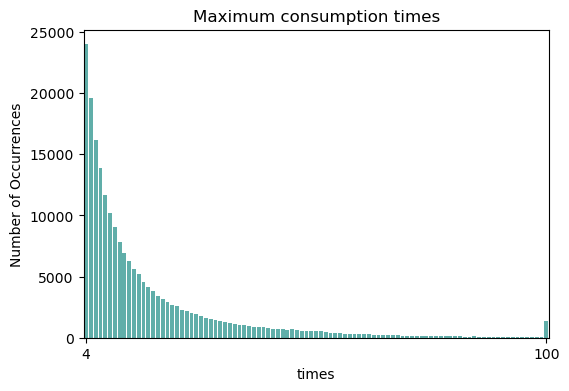

In [10]:
color='#28aaa2'
plt.figure(figsize=(6,4))
sns.barplot(x=consumption_times.index, y=consumption_times.values, alpha=0.8, color=color)
plt.title('Maximum consumption times')
plt.xlabel('times')
plt.ylabel('Number of Occurrences')
plt.xticks([0,96])
plt.show()

消費者消費次數分布從4次到100次，4次最多，呈現遞減趨勢

### 一周之中下單數分布狀況

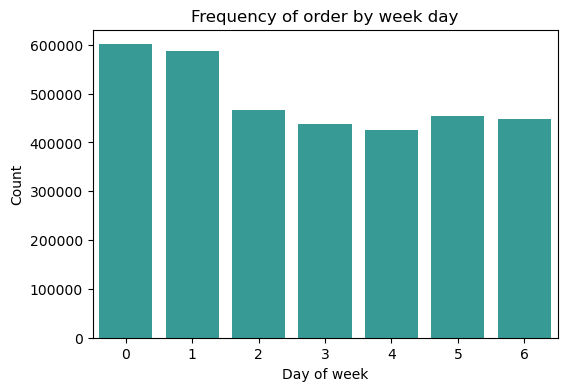

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='order_dow', data=orders, color=color)
plt.title("Frequency of order by week day")
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.show()

資料中沒有提到0到6分別代表星期幾，但我們推測下單數最多的兩天可能是週六和週日

### 一天之中下單數分布

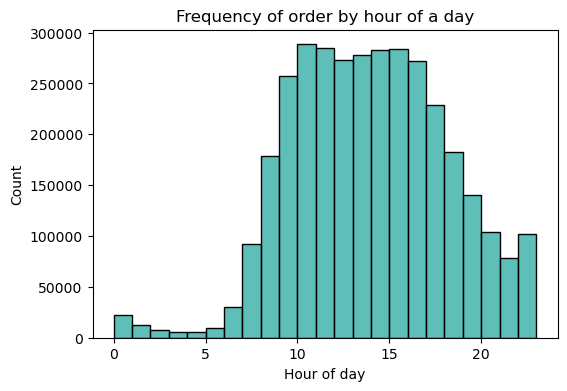

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(x='order_hour_of_day', data=orders, color=color, binwidth=1)
plt.title('Frequency of order by hour of a day')
plt.xlabel('Hour of day')
plt.ylabel('Count')
plt.show()

每天的下單時間集中白天，10到16點之間

In [13]:
# 製作新的data frame，內容包含幾乎所有訊息
merged_df=pd.merge(order_products_prior, products, on=['product_id','product_id'])
merged_df=pd.merge(merged_df, orders, on=['order_id','order_id'])
merged_df=pd.merge(merged_df, aisles, on=['aisle_id','aisle_id'])
merged_df.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs


In [14]:
merged_df.shape

(32434489, 14)

### 最熱銷的前20個商品種類

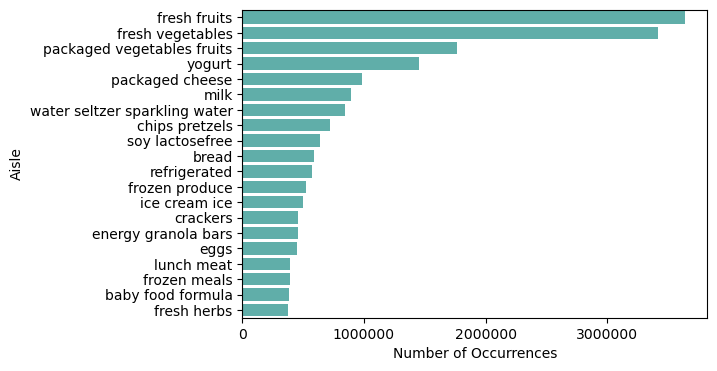

In [15]:
aisle_freq = merged_df.aisle.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=aisle_freq.index, x=aisle_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Aisle')
plt.xticks(np.arange(0,4000000,1000000),list(map(str,np.arange(0,4000000,1000000))))
plt.show()

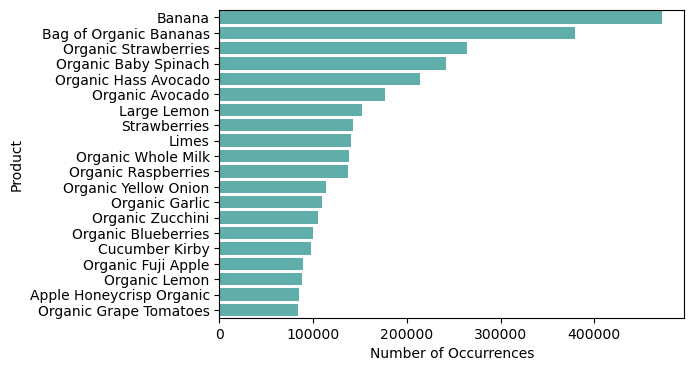

In [16]:
product_freq = merged_df.product_name.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=product_freq.index, x=product_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Product')
plt.show()

## 消費者分群

In [17]:
user_aisle_ct = pd.crosstab(merged_df.user_id, merged_df.aisle)
user_aisle_ct

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,...,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,3,4,0,2,1,0,0,11,0,15


先做主成分分析(PCA)把特徵濃縮到6個

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(user_aisle_ct)
pca_table=pd.DataFrame(pca.transform(user_aisle_ct))
pca_table

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466369,-0.145694,0.268982,-1.432906
1,6.463208,36.751116,8.382553,15.097526,-6.920949,-0.978559
2,-7.990302,2.404383,-11.030064,0.672248,-0.442325,-2.822933
3,-27.991129,-0.755823,-1.921732,2.091886,-0.288240,0.926145
4,-19.896394,-2.637225,0.533229,3.679233,0.612838,-1.623920
...,...,...,...,...,...,...
206204,-24.200168,1.369802,1.325348,4.935905,0.318361,0.004937
206205,-4.837135,-0.152500,5.263277,-21.059355,0.728863,-13.414858
206206,8.611433,7.701299,7.952402,-5.906225,1.718325,-3.266427
206207,84.086220,20.418734,8.054105,-15.558634,9.035049,-37.418816


In [19]:
# 六個主成分分別解釋了多少變異
pca.explained_variance_ratio_

array([0.48237998, 0.09585824, 0.05185877, 0.03590181, 0.0293466 ,
       0.02393094])

Text(0, 0.5, 'cumulated explained variance')

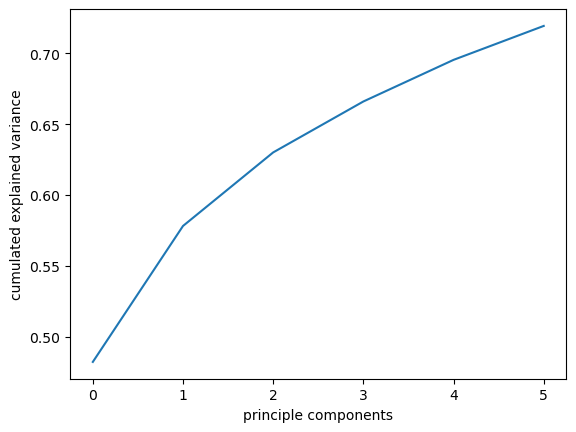

In [20]:
# 主成分解釋的變異累積圖
c_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(c_explained_variance_ratio)
plt.xlabel('principle components')
plt.ylabel('cumulated explained variance')

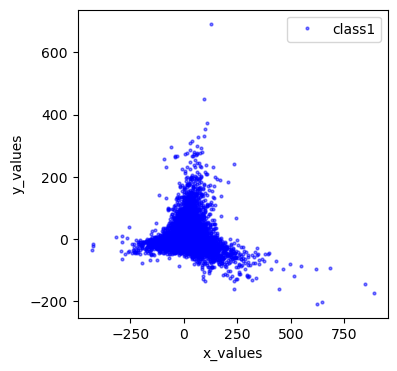

In [21]:
tocluster = pd.DataFrame(pca_table[[1,4]])

fig = plt.figure(figsize=(4,4))
plt.plot(tocluster[1], tocluster[4], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

### 利用elbow-method找出可能的分群數

Text(0.5, 1.0, 'KMeans elbow w/t Age')

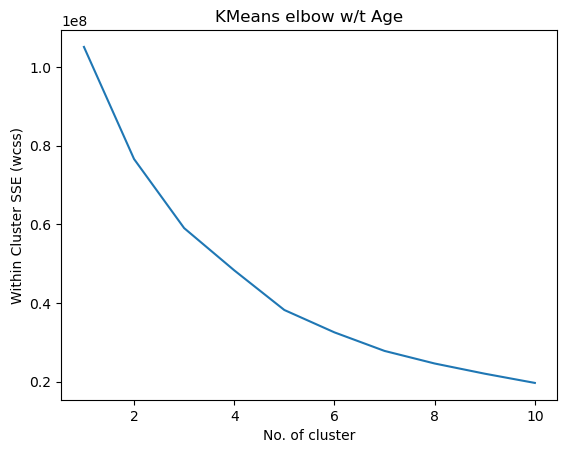

In [22]:
wcss = [] #within-cluster sum of squares
from sklearn.cluster import KMeans
for i in range(1,11): #跑10輪
    model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 2023)
    model.fit(tocluster)
    wcss.append(model.inertia_)
    
fig,ax = plt.subplots()
sns.lineplot(x = list(range(1,11)), y = wcss, ax = ax)
ax.set_xlabel('No. of cluster')
ax.set_ylabel('Within Cluster SSE (wcss)')
ax.set_title('KMeans elbow w/t Age')

依照elbow-method的結果可看出，可能的群數是3或5，但經過實驗後，我認為分成4群有較好的結果

In [23]:
#用KMeans將消費者分成4群並找出群中點
kmeans = KMeans(n_clusters=4,random_state=2023).fit(tocluster)
centers = kmeans.cluster_centers_
c_preds = kmeans.predict(tocluster)
print(centers)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-40.54683435  -4.70304129]
 [ 65.33966882 -11.29465454]
 [  0.10467716  -0.11831714]
 [ 26.26358548  76.82338964]]


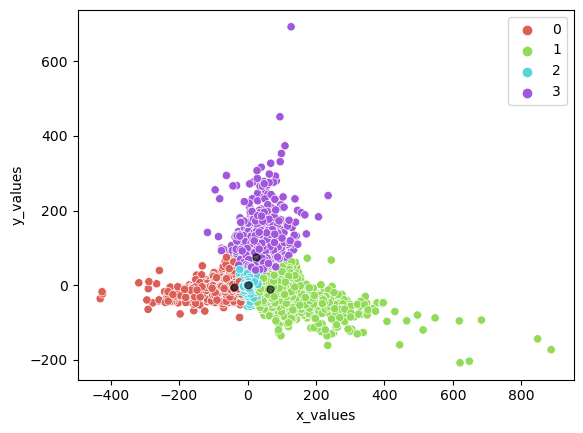

In [24]:
fig = plt.figure()
sns.scatterplot(
    x=tocluster[1],
    y=tocluster[4],
    hue=c_preds,
    palette = sns.color_palette('hls', 4)
)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=5, color='black', alpha=0.6)

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

試著找出新的觀點與模式

In [25]:
clustering_of_4_ct=user_aisle_ct.copy()
clustering_of_4_ct['cluster']=c_preds
clustering_of_4_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,2
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,2


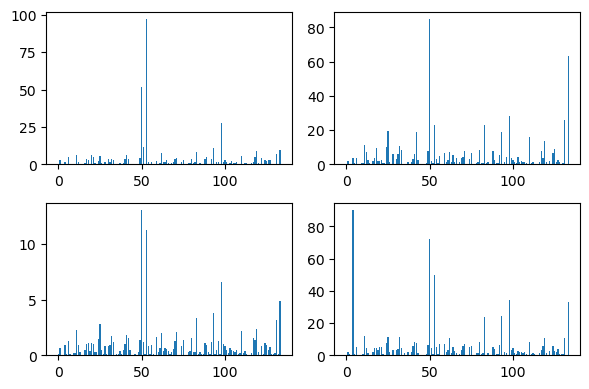

In [26]:
fig,axs = plt.subplots(2,2,figsize=(6,4))
feats=len(clustering_of_4_ct.drop('cluster',axis=1).columns)
c0 = clustering_of_4_ct[clustering_of_4_ct.cluster==0].drop('cluster',axis=1).mean()
axs[0, 0].bar(range(feats),c0)
c1 = clustering_of_4_ct[clustering_of_4_ct.cluster==1].drop('cluster',axis=1).mean()
axs[0, 1].bar(range(feats),c1)
c2 = clustering_of_4_ct[clustering_of_4_ct.cluster==2].drop('cluster',axis=1).mean()
axs[1, 0].bar(range(feats),c2)
c3 = clustering_of_4_ct[clustering_of_4_ct.cluster==3].drop('cluster',axis=1).mean()
axs[1, 1].bar(range(feats),c3)
#c4 = clustering_of_5_ct[clustering_of_5_ct.cluster==4].drop('cluster',axis=1).mean()
#axs[1, 1].bar(range(feats),c4)
plt.tight_layout()
plt.show()

In [27]:
c0.sort_values(ascending=False)[:10]

aisle
fresh vegetables                 96.824993
fresh fruits                     51.364873
packaged vegetables fruits       27.885686
fresh herbs                      11.303912
packaged cheese                  10.637365
yogurt                            9.916570
soy lactosefree                   8.791156
milk                              8.350371
frozen produce                    7.802435
water seltzer sparkling water     6.771909
dtype: float64

In [28]:
c1.sort_values(ascending=False)[:10]

aisle
fresh fruits                     84.531287
yogurt                           63.033564
packaged vegetables fruits       28.144206
water seltzer sparkling water    25.801653
fresh vegetables                 22.893237
milk                             22.759150
chips pretzels                   19.478664
packaged cheese                  19.049249
energy granola bars              19.048743
refrigerated                     16.020408
dtype: float64

In [29]:
c2.sort_values(ascending=False)[:10]

aisle
fresh fruits                     12.996668
fresh vegetables                 11.258623
packaged vegetables fruits        6.531979
yogurt                            4.840942
packaged cheese                   3.754952
milk                              3.303041
water seltzer sparkling water     3.169268
chips pretzels                    2.782891
soy lactosefree                   2.349889
bread                             2.278958
dtype: float64

In [30]:
c3.sort_values(ascending=False)[:10]

aisle
baby food formula             90.031453
fresh fruits                  72.334056
fresh vegetables              50.059111
packaged vegetables fruits    34.557484
yogurt                        33.242950
packaged cheese               24.305315
milk                          23.996746
bread                         12.200651
chips pretzels                11.457701
crackers                      11.247831
dtype: float64

這裡我們可以看到第0,1,2群的消費者購買的商品種類，與先前得到的熱銷排行前10商品，大致相同，只有排名的順序稍有不同  
熱銷排名前10商品:  
+ fresh fruits  
+ fresh vegetables  
+ packaged vegetables fruits  
+ yogurt  
+ packaged cheese  
+ milk  
+ water seltzer sparkling water  
+ chips pretzels  
+ soy lactosefree  
+ bread   

另外可以觀察到第3群消費者比較特別，他們購買較多baby food formula，是熱銷排行前10以外的商品

## 關聯分析

Association Rules關聯規則三大指標:  
* Support: 支持度，某item-set在資料庫中出現的頻率  
support(x->y) = p(x,y)，其中x->y表示一條規則  
用法: 設定最小支持度作為篩選條件  

* Confidence: 信賴度，兩項目集之間的條件機率    
越高表示該關聯性規則具有高度關係  
用法: 設定最小信賴度作為篩選條件  

* Lift: 提升度，依賴度與y項目發生機率的比  

In [32]:
# 把內容最齊全的data frame(merged_df)加上消費者分群結果
user_cluster_ct=clustering_of_4_ct.drop(columns=clustering_of_4_ct.columns[:-1],inplace=False)
merged_df=pd.merge(user_cluster_ct,merged_df,on=['user_id','user_id'])
merged_df.shape

In [37]:
# 用分群結果切割這個data frame
c0_merged_df=merged_df[merged_df.cluster==0]
c1_merged_df=merged_df[merged_df.cluster==1]
c2_merged_df=merged_df[merged_df.cluster==2]
c3_merged_df=merged_df[merged_df.cluster==3]

In [43]:
#製作新dataframe，將同群的消費者放在一起，內容只有order_id,product_name
c0_order_item = c0_merged_df[['order_id','product_name']]
c0_order_item.columns = ['order','item']
c0_order_item['temp'] = 1

c1_order_item = c1_merged_df[['order_id','product_name']]
c1_order_item.columns = ['order','item']
c1_order_item['temp'] = 1

c2_order_item = c2_merged_df[['order_id','product_name']]
c2_order_item.columns = ['order','item']
c2_order_item['temp'] = 1

c3_order_item = c3_merged_df[['order_id','product_name']]
c3_order_item.columns = ['order','item']
c3_order_item['temp'] = 1

C:\Users\jeff\AppData\Local\Temp\ipykernel_14284\4021627262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c0_order_item['temp'] = 1
C:\Users\jeff\AppData\Local\Temp\ipykernel_14284\4021627262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1_order_item['temp'] = 1
C:\Users\jeff\AppData\Local\Temp\ipykernel_14284\4021627262.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [55]:
c3_order_item=c3_order_item.reset_index(drop=True)
c3_order_item

,order,item,temp
0,2135028,Large Alfresco Eggs,1
1,3215600,Large Alfresco Eggs,1
2,1328876,Large Alfresco Eggs,1
3,22418,Large Alfresco Eggs,1
4,1148917,Large Alfresco Eggs,1
...,...,...,...
1233639,2778917,Organic Atage 3 Nibbly Fingers Mangoes Carrots,1
1233640,3416530,Organic Banana Blueberry Baby Food Puree,1
1233641,186354,Organic Banana Blueberry Baby Food Puree,1
1233642,186354,Organic Atage 3 Nibbly Fingers Mangoes Carrots,1
